In [1]:
import classy as Classy
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
sys.path.insert(0, '/Users/gabe/projects/recombination/src')
from RecTools import *

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

In [2]:
def maximum_uncertainty_mode(matrix, sig_prior=0, divider=5):

    standard_block = Fisher_full[:divider, :divider]
    cross_block = Fisher_full[:divider, divider:]
    perturbation_block = Fisher_full[divider:, divider:]

    marginalized = perturbation_block - np.einsum("ai,ij,jk->ak", cross_block.T, np.linalg.inv(standard_block), cross_block)

    H0_row = marginalized[0,1:]
    block = marginalized[1:,1:]
    binv = np.linalg.inv(block)

    mode = np.einsum("i,ij->j", H0_row, binv)

    F_00 = marginalized[0,0]
    num = np.einsum("a,ab,b", H0_row, binv, H0_row)
    sig2 = 1./(F_00-num)

    norm = np.abs(np.einsum("i,ij,j", mode.T, binv, mode)) ##normalizing the uncertainty to be unit
    norm = np.abs(np.einsum("i,i", mode.T, mode)) ##normalizing the uncertainty to be unit
    mode*=1./np.sqrt(norm)

    fun = scipy.interpolate.CubicSpline(FisherContainer.pivots, mode)
    zs = np.linspace(FisherContainer.zmin, FisherContainer.zmax, 10000)

    return fun, sig2, zs
    

# No priors

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from matplotlib import cm

path = "/Users/gabe/projects/recombination/data/Jun07.NewH0Test.0"
print(path)
FisherContainer = FisherData(path)

/Users/gabe/projects/recombination/data/Jun07.NewH0Test.0
{'omega_b': '0.02242', 'omega_cdm': '0.11933', 'n_s': '0.9665', 'tau_reio': '0.0561', 'ln10^{10}A_s': '3.047', 'H0': '67.66'}


In [4]:
Fisher_full = FisherContainer.Fisher_full

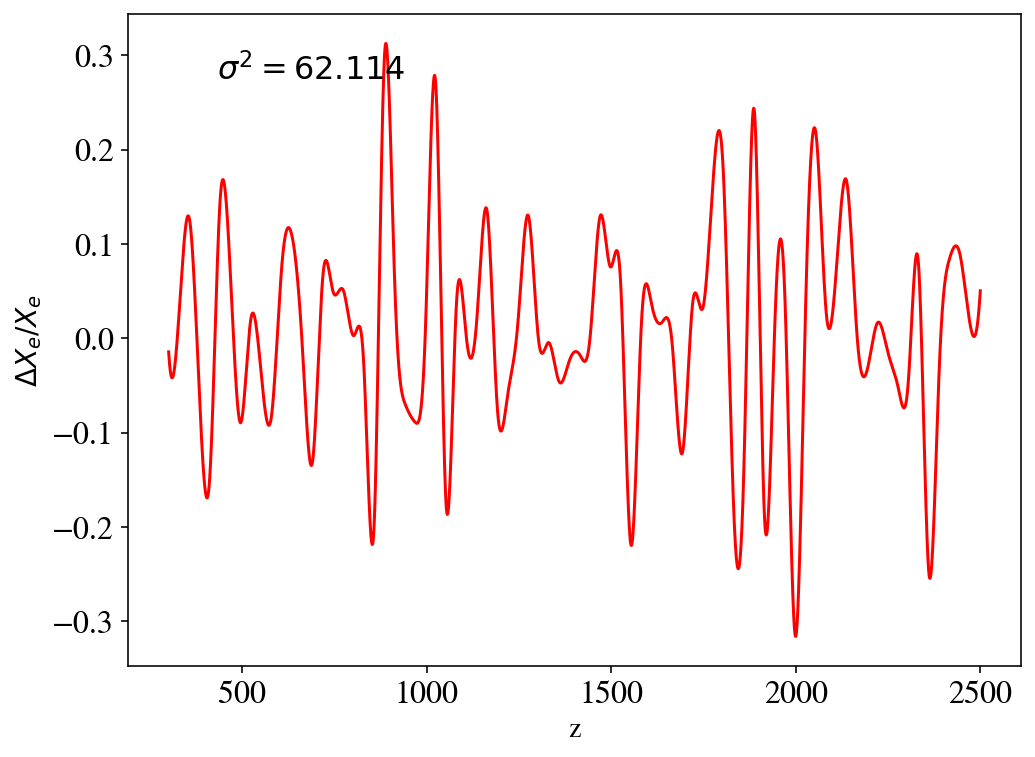

In [5]:
fsize=14
divider = 5

standard_block = Fisher_full[:divider, :divider]
cross_block = Fisher_full[:divider, divider:]
perturbation_block = Fisher_full[divider:, divider:]

marginalized = perturbation_block - np.einsum("ai,ij,jk->ak", cross_block.T, np.linalg.inv(standard_block), cross_block)

H0_row = marginalized[0,1:]
block = marginalized[1:,1:]
binv = np.linalg.inv(block)

mode = np.einsum("i,ij->j", H0_row, binv)

F_00 = marginalized[0,0]
num = np.einsum("a,ab,b", H0_row, binv, H0_row)
sig2 = 1./(F_00-num)

norm = np.abs(np.einsum("i,ij,j", mode.T, binv, mode)) ##normalizing the uncertainty to be unit
norm = np.abs(np.einsum("i,i", mode.T, mode)) ##normalizing the uncertainty to be unit
mode*=1./np.sqrt(norm)

fun = scipy.interpolate.CubicSpline(FisherContainer.pivots, mode)
zs = np.linspace(FisherContainer.zmin, FisherContainer.zmax, 10000)

fig,ax=plt.subplots()
ax.plot(zs, fun(zs), color='r')

ax.set_xlabel("z", fontsize=fsize)
ax.set_ylabel("$\Delta X_e/X_e$", fontsize=fsize)

ax.text(0.1, 0.9, "$\sigma^2 = {:.3f}$".format(sig2), transform=ax.transAxes)

fun_np = fun
#plt.savefig("../results/H0_mode_no_prior_talk.png", dpi=300, bbox_inches='tight')

# With priors (single)

(86, 86)
1.0000329756542001


/var/folders/dx/56r119096g71nr7d270292b80000gn/T/ipykernel_32255/376871580.py:56: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  print(scipy.integrate.quad(square(fun), FisherContainer.pivots[0], FisherContainer.pivots[-1])[0])


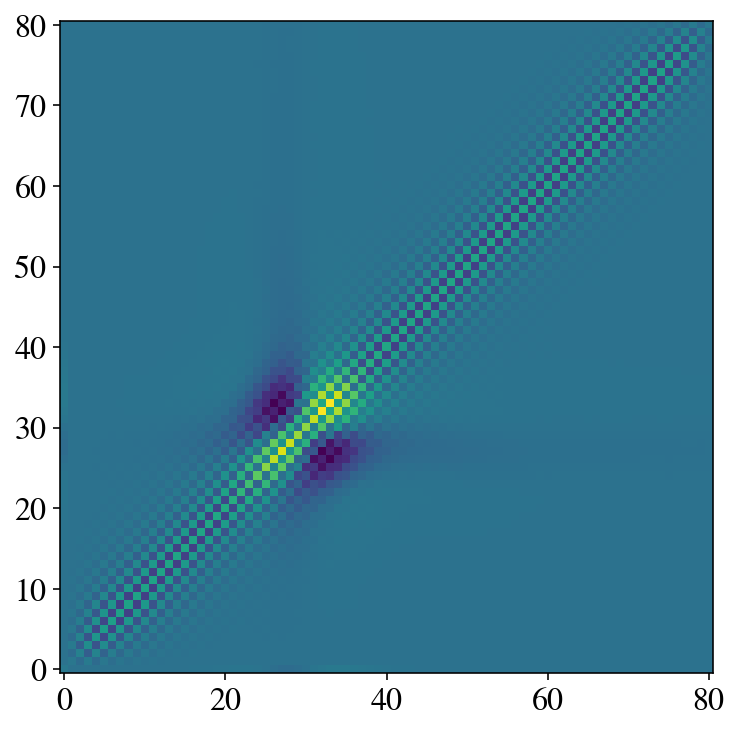

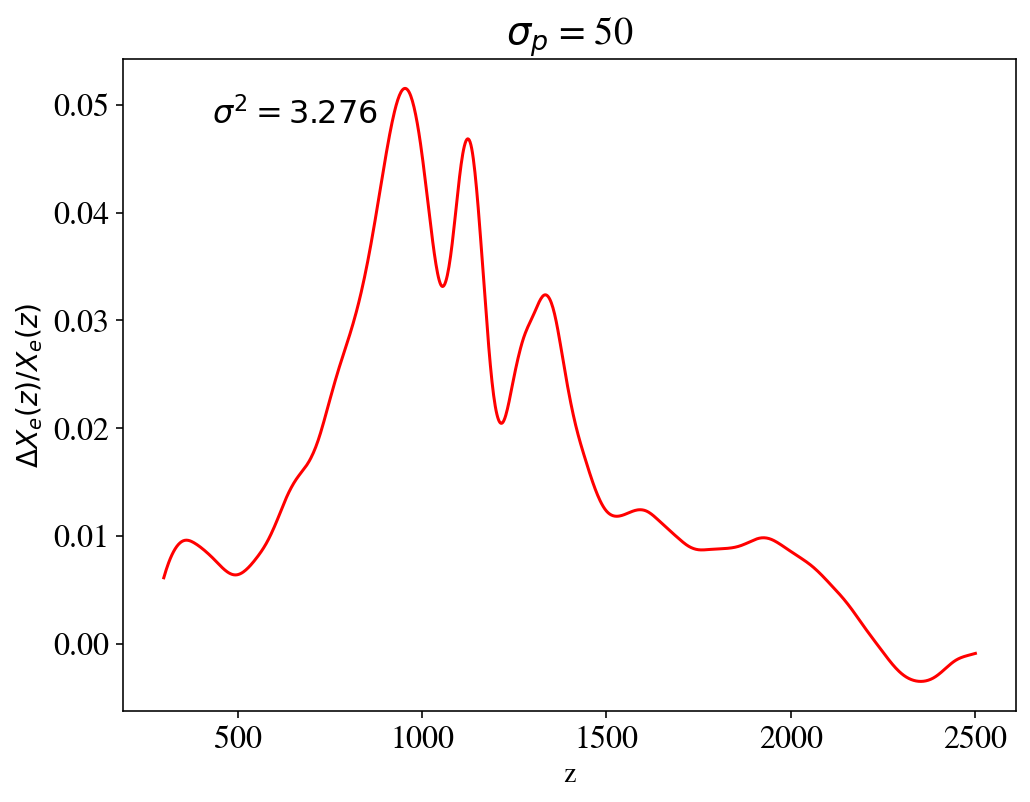

In [16]:
Fisher_new = Fisher_full.copy()

print(Fisher_full.shape)
Npert = int(len(FisherContainer.pivots))

Fprior_block = np.zeros((Npert,Npert))

#sig_prior = 2*data.dz
sig_prior = 50
#sig_prior = 850
#sig_prior = 75.160371
#sig_prior=76

for i in np.arange(Npert):
    for j in np.arange(Npert):
        #Fprior_block[i,j] = (1/np.sqrt(2*np.pi*sig_prior**2))*np.exp(-0.5*(data.pivots[i]-data.pivots[j])**2/sig_prior**2)
        Fprior_block[i,j] = np.exp(-(FisherContainer.pivots[i]-FisherContainer.pivots[j])**2/sig_prior**2)


Fprior_block = np.linalg.pinv(Fprior_block)
Fprior = np.zeros(Fisher_new.shape)
Fprior[6:, 6:] = Fprior_block

Fisher_new+=Fprior

####################
# Calculating the mode
#
#####################
divider = 5

standard_block = Fisher_new[:divider, :divider]
cross_block = Fisher_new[:divider, divider:]
perturbation_block = Fisher_new[divider:, divider:]

marginalized = perturbation_block - np.einsum("ai,ij,jk->ak", cross_block.T, np.linalg.inv(standard_block), cross_block)

fig,ax = plt.subplots()
m=ax.imshow(marginalized, origin='lower', cmap=cm.viridis)

H0_row = marginalized[0,1:]
block = marginalized[1:,1:]
binv = np.linalg.inv(block)

mode = np.einsum("i,ij->j", H0_row, binv)

F_00 = marginalized[0,0]
num = np.einsum("a,ab,b", H0_row, binv, H0_row)
sig2 = 1./(F_00-num)

#norm = np.abs(np.einsum("i,ij,j", mode.T, binv, mode)) ##normalizing the uncertainty to be unit
norm = np.trapz(mode**2, FisherContainer.pivots) ##normalizing the uncertainty to be unit
mode *= 1./np.sqrt(norm)

fun = scipy.interpolate.CubicSpline(FisherContainer.pivots, mode)
print(scipy.integrate.quad(square(fun), FisherContainer.pivots[0], FisherContainer.pivots[-1])[0])
#fun = renormalize(1/np.sqrt(norm))(fun)

np.save("hubble_mode", mode)
np.save("hubble_pivots", FisherContainer.pivots)

zs = np.linspace(FisherContainer.zmin, FisherContainer.zmax, 1000)


fig,ax=plt.subplots()
ax.plot(zs, fun(zs), color='r')

ax.set_xlabel("z", fontsize=14)
ax.set_ylabel("$\Delta X_e(z)/X_e(z)$", fontsize=14)
ax.set_title("$\sigma_p$ = {}".format(sig_prior))

ax.text(0.1, 0.9, "$\sigma^2 = {:.3f}$".format(sig2), transform=ax.transAxes)

fun_mp = fun 

#plt.savefig("../results/H0_mode_prior_max.pdf", dpi=300, bbox_inches='tight')

## sigma(H0) is a monotonic function

In [23]:
#prior_sigmas = np.logspace(0, 2, 100)
prior_sigmas = np.linspace(1, 100, 1000)

H0_sigmas = []

for sig_prior in prior_sigmas:
    Fisher_new = Fisher_full.copy()
    Fprior_block = np.zeros((Npert,Npert))
    
    for i in np.arange(Npert):
        for j in np.arange(Npert):
            #Fprior_block[i,j] = (1/np.sqrt(2*np.pi*sig_prior**2))*np.exp(-0.5*(data.pivots[i]-data.pivots[j])**2/sig_prior**2)
            Fprior_block[i,j] = np.exp(-(FisherContainer.pivots[i]-FisherContainer.pivots[j])**2/sig_prior**2)


    Fprior_block = np.linalg.pinv(Fprior_block)

    Fprior = np.zeros(Fisher_full.shape)
    Fprior[6:, 6:] = Fprior_block

    Fisher_new+=Fprior

    ####################
    # Calculating the mode
    #####################
    divider = 5

    standard_block = Fisher_new[:divider, :divider]
    cross_block = Fisher_new[:divider, divider:]
    perturbation_block = Fisher_new[divider:, divider:]

    marginalized = perturbation_block - np.einsum("ai,ij,jk->ak", cross_block.T, np.linalg.inv(standard_block), cross_block)

    H0_row = marginalized[0,1:]
    block = marginalized[1:,1:]
    binv = np.linalg.inv(block)

    mode = np.einsum("i,ij->j", H0_row, binv)

    F_00 = marginalized[0,0]
    num = np.einsum("a,ab,b", H0_row, binv, H0_row)
    sig2 = 1./(F_00-num)
    H0_sigmas.append(sig2)

H0_sigmas = np.array(H0_sigmas)

Max is σ_H0=4.290863351929707 at σ_prior=100.0
2.0714399223558733


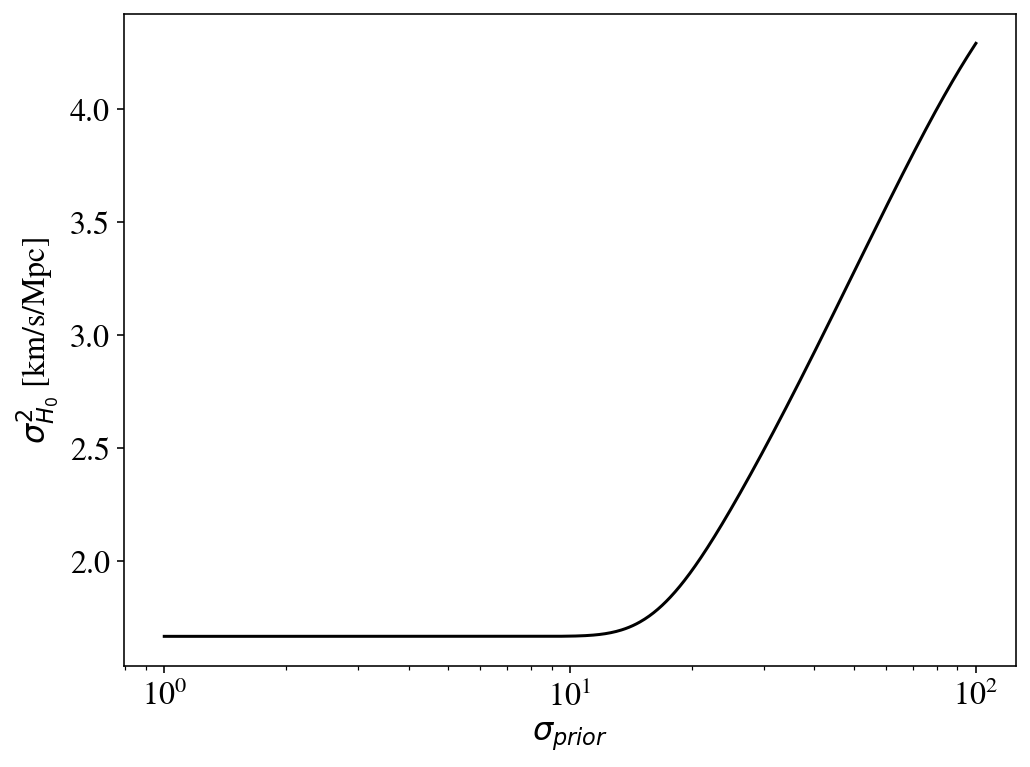

In [24]:
fig, ax = plt.subplots()

print("Max is σ_H0={} at σ_prior={}".format(np.max(H0_sigmas), prior_sigmas[np.argmax(H0_sigmas)]))
ax.plot(prior_sigmas, H0_sigmas, color='k')
#ax.plot(prior_sigmas, derivative[idx]*(prior_sigmas-prior_sigmas[idx])+H0_sigmas[idx])
#ax.set_ylim([0.00, 1.2])
ax.set_xlabel("$\sigma_{prior}$")
ax.set_ylabel("$\sigma^2_{H_0}$ [km/s/Mpc]")
ax.set_xscale('log')

print(np.sqrt(np.max(H0_sigmas)))

#plt.savefig("../results/sigma_h0_dependency.pdf", dpi=300, bbox_inches='tight')
plt.show()


## Collecting into a single cell

In [25]:
import scipy.integrate

dz = FisherContainer.pivots[1] - FisherContainer.pivots[0]

prior_list = np.logspace(-4,np.log10(2.7),100)*dz
print(prior_list)
output_dict={}
H0_sig = {}

def apply_norm(norm):
    def dec(f):
        def wrapper(*args, **kwargs):
            return f(*args, **kwargs)/norm
        return wrapper
    return dec

for sig_prior in prior_list:
    ################################
    # Calculate Fisher matrix
    ################################
    #print("σ_prior={}".format(sig_prior))
    Fisher_new = Fisher_full.copy()

    ################################
    # Adding a smoothness prior
    ################################

    Fprior_block = np.zeros((Npert,Npert))

    #sig_prior = 1*dz
    for i in np.arange(Npert):
        for j in np.arange(Npert):
            #Fprior_block[i,j] = (1/np.sqrt(2*np.pi*sig_prior**2))*np.exp(-0.5*(data.pivots[i]-data.pivots[j])**2/sig_prior**2)
            Fprior_block[i,j] = np.exp(-(FisherContainer.pivots[i]-FisherContainer.pivots[j])**2/sig_prior**2)


    Fprior_block = np.linalg.pinv(Fprior_block)

    Fprior = np.zeros(Fisher_new.shape)
    Fprior[6:, 6:] = Fprior_block

    Fisher_new+=Fprior

    ####################
    # Calculating the mode
    #
    #####################
    divider = 5

    standard_block = Fisher_new[:divider, :divider]
    cross_block = Fisher_new[:divider, divider:]
    perturbation_block = Fisher_new[divider:, divider:]

    marginalized = perturbation_block - np.einsum("ai,ij,jk->ak", cross_block.T, np.linalg.inv(standard_block), cross_block)

    H0_row = marginalized[0,1:]
    block = marginalized[1:,1:]
    binv = np.linalg.inv(block)
    
    mode = np.einsum("i,ij->j", H0_row, binv)

    F_00 = marginalized[0,0]
    num = np.einsum("a,ab,b", H0_row, binv, H0_row)
    sig2 = 1./(F_00-num)
    H0_sig.update({sig_prior:np.sqrt(sig2)})

    #norm = np.abs(np.einsum("i,i", mode.T, mode)) ##normalizing the uncertainty to be unit
    mode*=1./np.sqrt(2*np.pi*FisherContainer.width**2)

    Id = np.diag([1.]*binv.shape[0])

    #norm = np.einsum("i,ij,jk,kl,l", H0_row.T, binv, Id, binv, H0_row)
    norm = np.abs(np.einsum("i,i", mode.T, mode)) ##normalizing the uncertainty to be unit
    mode*=1./np.sqrt(norm)

    #mode*=1./np.sqrt(norm)

    fun = scipy.interpolate.CubicSpline(FisherContainer.pivots, mode)

    output_dict.update({sig_prior: fun})


[2.78481013e-03 3.08714366e-03 3.42230010e-03 3.79384287e-03
 4.20572227e-03 4.66231745e-03 5.16848298e-03 5.72960049e-03
 6.35163584e-03 7.04120260e-03 7.80563233e-03 8.65305255e-03
 9.59247313e-03 1.06338821e-02 1.17883519e-02 1.30681569e-02
 1.44869043e-02 1.60596783e-02 1.78032009e-02 1.97360094e-02
 2.18786536e-02 2.42539145e-02 2.68870462e-02 2.98060443e-02
 3.30419442e-02 3.66291502e-02 4.06058021e-02 4.50141800e-02
 4.99011545e-02 5.53186845e-02 6.13243698e-02 6.79820637e-02
 7.53625516e-02 8.35443038e-02 9.26143098e-02 1.02669003e-01
 1.13815286e-01 1.26171668e-01 1.39869523e-01 1.55054489e-01
 1.71888015e-01 1.90549075e-01 2.11236078e-01 2.34168970e-01
 2.59591576e-01 2.87774194e-01 3.19016463e-01 3.53650557e-01
 3.92044708e-01 4.34607130e-01 4.81790350e-01 5.34096026e-01
 5.92080281e-01 6.56359608e-01 7.27617435e-01 8.06611385e-01
 8.94181329e-01 9.91258325e-01 1.09887451e+00 1.21817406e+00
 1.35042540e+00 1.49703464e+00 1.65956053e+00 1.83973109e+00
 2.03946191e+00 2.260876

Text(0.5, 0, 'z')

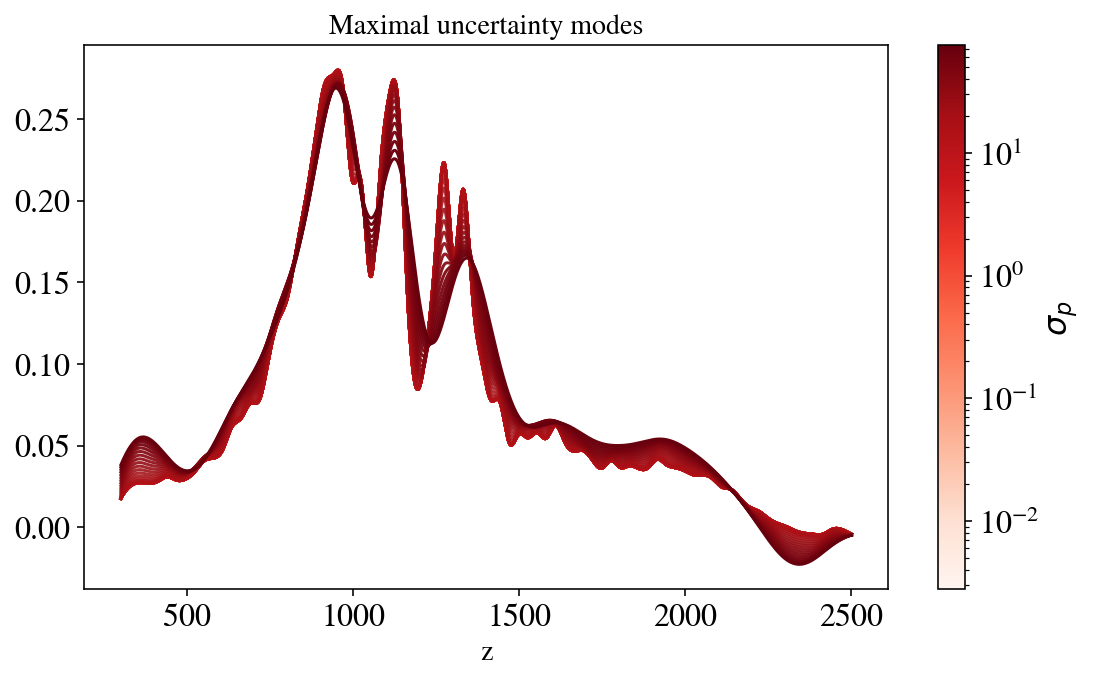

In [26]:
import matplotlib as mpl
import cycler
n = len(output_dict)
my_cm = plt.cm.Reds
color = my_cm(np.linspace(0,1,n))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

zs = np.linspace(FisherContainer.zmin, FisherContainer.zmax, 10000)  
fig,ax=plt.subplots(figsize=(9,5))
i=0
for sig, fun in output_dict.items():
    #ax.plot(zs, fun(zs), color="k", alpha=i/(len(output_dict)), label="$\sigma = {}$".format(sig))
    ax.plot(zs, fun(zs), alpha=i/n, label="$\sigma = {}$".format(sig))
    i+=1

sm = plt.cm.ScalarMappable(cmap=my_cm, norm=LogNorm(vmin=prior_list[0], vmax=prior_list[-1]))
cbar = plt.colorbar(sm, label="$\sigma_p$")
    
ax.set_title(r"Maximal uncertainty modes".format(sig_prior), fontsize=14)
ax.set_xlabel("z", fontsize=fsize)
#ax.axvline(1100, color='k')
#ax.axvline(1800, color='k')
#ax.text(0.15, 0.85, "$\sigma^2 = {:.3f}$".format(sig2), transform=ax.transAxes)
#plt.legend()
#plt.show()

#plt.savefig("../results/H0_mode_sigprior_dependence.png", dpi=300, bbox_inches='tight')

## Projecting onto principal components

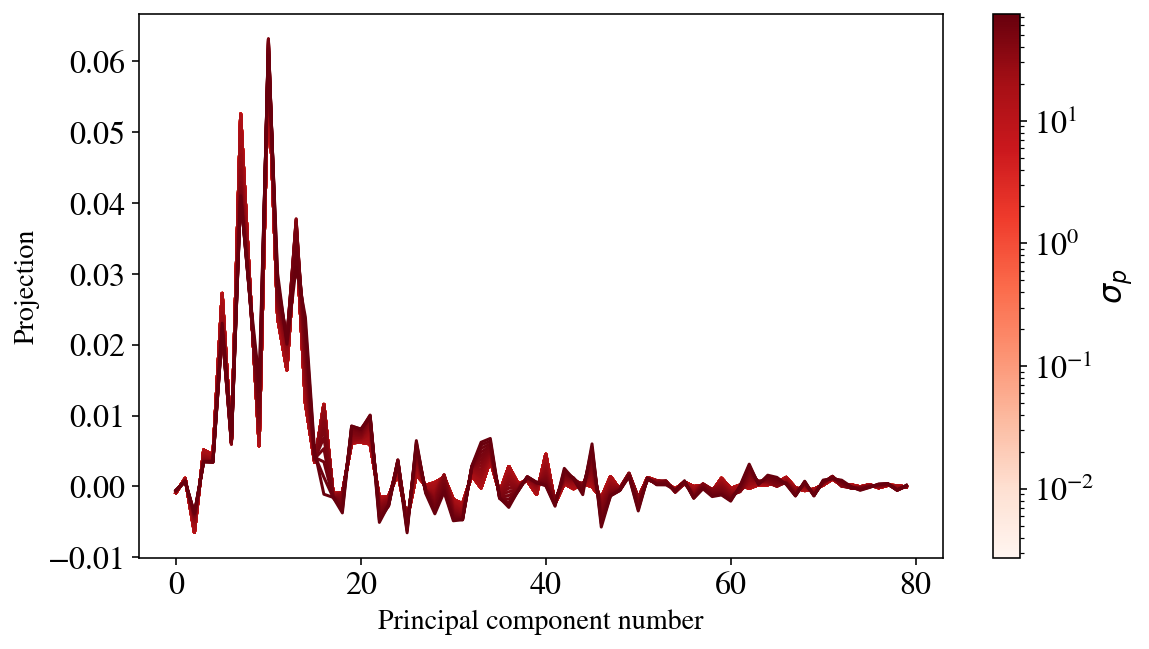

In [36]:
pca = PCA(data, fisher='m')
exem_matrix = pca.eigenvecs

n = len(output_dict)
my_cm = plt.cm.Reds
colorc = my_cm(np.linspace(0,1,n))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', colorc)

fig,ax=plt.subplots(figsize=(9,5))
i=0
for sig, fun in output_dict.items():
    #if i==0 or i==len(output_dict)-1:
        #print(sig)
    projection = np.einsum("ij,j->i", exem_matrix, fun(data.pivots))
    ax.plot(np.arange(int(data.Npert)), projection, label="$\sigma_p={}$".format(sig))
        #ax.scatter(np.arange(Npert), projection, label="$\sigma={}$".format(sig))
    i+=1


sm = plt.cm.ScalarMappable(cmap=my_cm, norm=LogNorm(vmin=prior_list[0], vmax=prior_list[-1]))
cbar = plt.colorbar(sm, label="$\sigma_p$")
ax.set_xlabel("Principal component number", fontsize=14)
ax.set_ylabel("Projection", fontsize=14)

#plt.legend()
plt.savefig("../results/H0_mode_sigprior_projections.png", dpi=300, bbox_inches='tight')
plt.show()

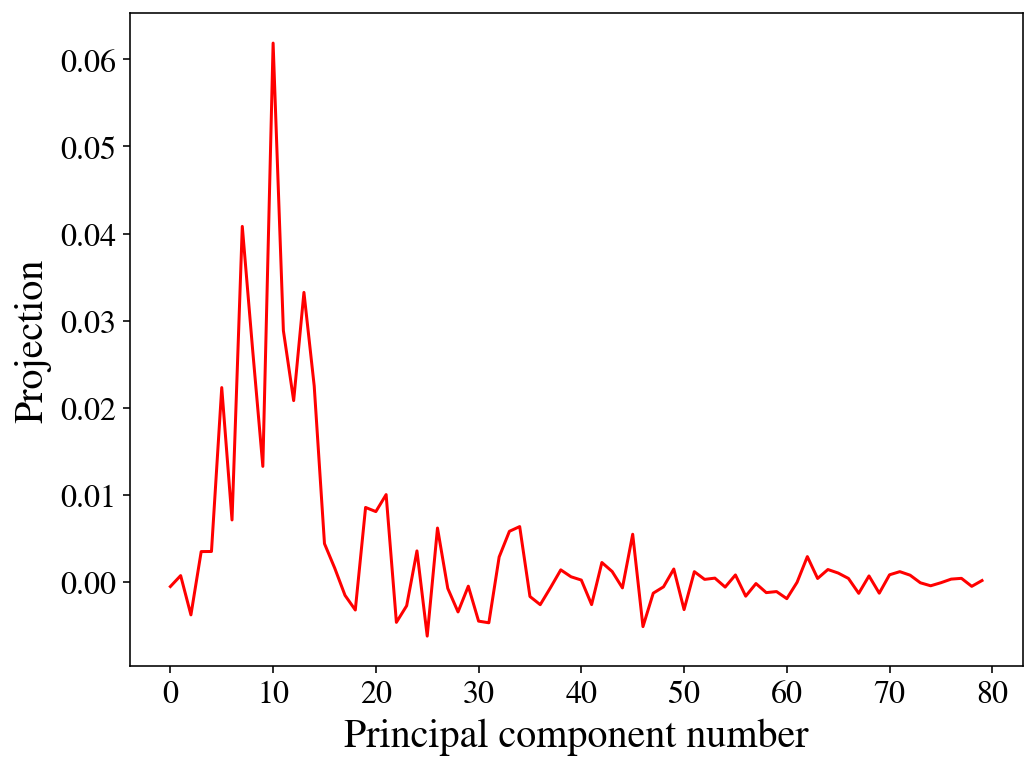

In [72]:
pca = PCA(data, fisher='m')
exem_matrix = pca.eigenvecs

fig,ax=plt.subplots()

projection = np.einsum("ij,j->i", exem_matrix, fun_mp(data.pivots))
ax.plot(np.arange(int(data.Npert)), projection, color="r")

ax.set_xlabel("Principal component number", fontsize=fsize)
ax.set_ylabel("Projection", fontsize=fsize)

#plt.legend()
plt.savefig("../results/H0_mode_no_prior_projection.png", dpi=300, bbox_inches='tight')
plt.show()